In [1777]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_blobs
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import cv2

In [1001]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = (Z > 0.5).astype(int).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()



def plot_decision_boundary_one_hot(model, X, y, resolution=0.02):
    # Define the color maps
    markers = ('s', 'x', 'o', '^', 'v', '+', 'p', 'd', 'h', '8', '<', '>')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(np.argmax(y, axis=1)))])

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))

    # Flatten the grid to pass it through the model
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict class probabilities for each point in the mesh grid
    Z = model.forward(grid)
    
    # Convert probabilities to class labels
    Z = np.argmax(Z, axis=1)
    
    # Reshape the results to match the mesh grid
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # Plot the data points
    for idx, cl in enumerate(np.unique(np.argmax(y, axis=1))):
        plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0], 
                    y=X[np.argmax(y, axis=1) == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=f'Class {cl}', 
                    edgecolor='black')

    plt.legend(loc='upper left')
    plt.show()

# Example usage
# Assuming you have a trained model and data X, y
# model = ... # Your trained model
# X = ...     # Your input features
# y = ...     # Your one-hot encoded labels


Gradient descent

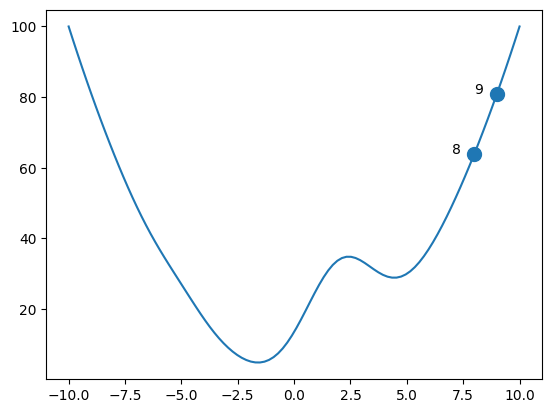

In [3]:
def sphere_2D(x):
    return x**2

def sphere_with_holes(x):
    return x**2 + 30*np.exp(-0.2*(x-2)**2) + 2*np.exp(-0.5*(x+5)**2)

def rasstrigin_2D(x):
    return x**2 - 22*np.cos(2*np.pi*x) + 20

def min_fn(x):
    return sphere_with_holes(x)

x_min = -10
x_max = 10

def plot_curve():
    x_sp = np.linspace(x_min, x_max, 100)
    y_sp = min_fn(x_sp)
    plt.plot(x_sp, y_sp)

def sp(x_p):
    plot_curve()

    plt.scatter([x_p],min_fn(x_p), s=200)
    plt.show()

def sp_many(x):
    plot_curve()

    plt.scatter(x,[min_fn(x) for x in x], s=100)
    for x in x:
        plt.text(x - 1, min_fn(x), x)


sp_many([8, 9])



In [4]:
x_train = np.array([
    [1, 1],
    [0, 1],
    [1, 0],
    [0, 0],
])

y_train = np.array([
    [1],
    [0],
    [0],
    [0],
])

# y_train = np.array([
#     [0],
#     [1],
#     [1],
#     [0],
# ])

# np.random.seed(0)

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs

    def __init__(self, inputs_len, neurons_len, activation=relu):
        self.weights = np.random.rand(inputs_len, neurons_len)
        self.biases = np.zeros(neurons_len)
        self.activation = activation

    def forward(self, inputs):
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)



class NeuralNetwork:
    def __init__(self):
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

    def fit(self, inputs, targets, lp=0.01, n_iter=10):
        for _ in range(n_iter):
            print(f'iter {_}')
            for input, target in zip(inputs, targets):
                self.updateWeightsBiases(input, target, lp)

    def updateWeightsBiases(self, input, target, lp):
        self.forward(input)
        loss = self.calculate_loss(target)
        print(f'loss {loss}')

        for layer in self.layers:
            for i in range(len(layer.weights)):
                layer.weights[i] = layer.weights[i] + lp * loss * input[i]

            layer.biases = layer.biases + lp * loss 

    def calculate_loss(self, target):
        # return np.mean((target - self.output)**2)
        return target - self.layers[-1].output
    
    def predict(self, inputs):
        self.forward(inputs)
        return self.layers[-1].output


mlp = NeuralNetwork()


mlp.add(LayerDense(2, 1, LayerDense.heaviside))





In [6]:
mlp.fit(x_train, y_train, 0.1, 3)

iter 0
loss [0.]
loss [-1.]
loss [0.]
loss [0.]
iter 1
loss [1.]
loss [-1.]
loss [0.]
loss [0.]
iter 2
loss [0.]
loss [0.]
loss [0.]
loss [0.]


In [7]:
mlp.layers[0].weights

array([[0.15367981],
       [0.43611684]])

In [2231]:
mlp.layers[0].output

array([0.])

In [8]:
plot_decision_boundary(mlp, x_train, y_train)

TypeError: '>' not supported between instances of 'NoneType' and 'float'

backpropagation

In [11]:
def df(f, a):
    h = 0.0001
    return ( f(a + h) - f(a) ) / h

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def df_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [12]:
df(LayerDense.relu, 4)

0.9999999999976694

In [1408]:
def standard_scaler(x):
    """
     convert the data to have a mean of 0 and a standard deviation of 1
    """
    
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

In [1832]:
np.random.seed(0)

class LayerDense:
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x):
        x = np.clip(x, -500, 500)
                
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def heaviside(x):
        return np.heaviside(x, 0)
    
    @staticmethod
    def softmax(x):
        exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probs
    
    
    def df_activation(self, activated_output):
        """
            activated_output -> aL = σ(zL)
        """

        if self.activation == LayerDense.sigmoid:
            return activated_output * (1 - activated_output)
        elif self.activation == LayerDense.relu:
            return np.where(activated_output <= 0, 0, 1)
        elif self.activation == LayerDense.softmax:
            batch_size = activated_output.shape[0]
            # Initialize the tensor for storing the derivatives
            d_softmax = np.zeros((batch_size, activated_output.shape[1], activated_output.shape[1]))
            for i in range(batch_size):
                s = activated_output[i].reshape(-1, 1)
                d_softmax[i] = np.diagflat(s) - np.dot(s, s.T)

            return d_softmax


    def __init__(self, inputs_len, neurons_len, activation=relu):
        self.weights = np.random.randn(inputs_len, neurons_len) * np.sqrt(2. / inputs_len)
        # print(self.weights)
        self.biases = np.zeros(neurons_len)
        self.activation = activation

    def forward(self, inputs):
        self.output = self.activation(np.dot(inputs, self.weights) + self.biases)
        return self.output


class NeuralNetwork:
    @staticmethod
    def loss_mse(y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    @staticmethod
    def df_loss_mse(y_true, y_pred):
        return y_pred - y_true
    
    @staticmethod
    def loss_binary_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    @staticmethod
    def loss_categorical_crossentropy(y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred))

    def __init__(self, loss=loss_mse):
        self.loss = loss
        self.layers = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            layer.forward(inputs)
            inputs = layer.output

        return inputs
    
    def calculate_output_delta(self, layer, y_true, y_pred):
        if layer.activation == LayerDense.softmax:
            return y_pred - y_true
        if layer.activation == LayerDense.sigmoid:
            grad_loss_input = self.df_loss_mse(y_true, y_pred) # derivative of loss function = ∇aL | samples -> neurons
            activation_derivative = layer.df_activation(layer.output) # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) | samples -> neurons

            return grad_loss_input * activation_derivative # δL = ∇aL * σ'(zL) | samples -> neurons

    def backward_auto(self, inputs, y_true, y_pred, lp, batch_size):
        layers_count = len(self.layers)

        for layer_index in reversed(range(0, layers_count)):
            layer = self.layers[layer_index]

            is_output_layer = layer_index == layers_count - 1
            
            if is_output_layer:
                # output layer
                layer.delta = self.calculate_output_delta(layer, y_true, y_pred)
            else:
                prev_backward_layer = self.layers[layer_index + 1]        

                layer.propagated_error = np.dot(prev_backward_layer.delta, prev_backward_layer.weights.T) # δL * wL.T

                layer.activation_derivative = layer.df_activation(layer.output) 
                layer.delta = layer.propagated_error * layer.activation_derivative

            if layer_index != 0:
                next_backward_layer = self.layers[layer_index - 1]

                next_backward_layer_output = next_backward_layer.output.T
            else:
                next_backward_layer_output = inputs.T

            layer.grad_loss_weights = np.dot(next_backward_layer_output, layer.delta) # ∇wL = aL-1.T * δL | neurons -> neurons
            layer.grad_loss_biases = np.sum(layer.delta, axis=0, keepdims=True)  # ∇bL = δL | neurons -> 1

            np.clip(layer.grad_loss_weights, -1, 1, out=layer.grad_loss_weights)
            np.clip(layer.grad_loss_biases, -1, 1, out=layer.grad_loss_biases)

            layer.weights = layer.weights - lp * layer.grad_loss_weights / batch_size
            layer.biases = layer.biases - lp * layer.grad_loss_biases / batch_size

    # def test_backward_2_layers_only(self, inputs, y_true, y_pred, lp, batch_size):
    #     output_layer = self.layers[1]
        
    #      # derivative of loss function df_loss
    #      # derivative of sigmoid(zL) = sigmoid(zL) * (1 - sigmoid(zL)) df_activation
        
    #     # print(self.df_loss(y_true, y_pred))

    #     output_delta = self.df_loss_mse(y_true, y_pred) * output_layer.df_activation(output_layer.output) # ∇aL * σ'(zL) | for sigmoid output layer
    #     # output_delta = y_pred - y_true 
        
    #     hidden_layer = self.layers[0]
        
    #     vw_loss_output = np.dot(hidden_layer.output.T, output_delta) # ∇wL = aL-1.T * δL
    #     vb_loss_output = np.sum(output_delta, axis=0, keepdims=True) # ∇bL = δL
    #     # print('weight',output_layer.weights)
    #     # print('vw_loss_output', vw_loss_output)
    #     # print('----------------------------------------')

    #     output_layer.weights = output_layer.weights - lp * vw_loss_output / batch_size
    #     output_layer.biases = output_layer.biases - lp * vb_loss_output / batch_size
        
    #     # next prev layer

    #     activated_weights_from_output_to_hidden = output_layer.weights.T
    #     hidden_error = np.dot(output_delta, activated_weights_from_output_to_hidden) # δL * wL.T

    #     hidden_derivative_activated = hidden_layer.df_activation(hidden_layer.output) 
    #     hidden_delta = hidden_error * hidden_derivative_activated

    #     vw_loss_hidden = np.dot(inputs.T, hidden_delta)
    #     vb_loss_hidden = np.sum(hidden_delta, axis=0, keepdims=True)

    #     hidden_layer.weights = hidden_layer.weights - lp * vw_loss_hidden / batch_size
    #     hidden_layer.biases = hidden_layer.biases - lp * vb_loss_hidden / batch_size

    def validation_train_split(self, inputs, y_true, validation_split, log=True):
        x_val = inputs[-int(len(inputs) * validation_split):]
        y_val = y_true[-int(len(inputs) * validation_split):]
        x_true = inputs[:-int(len(inputs) * validation_split)]
        y_true = y_true[:-int(len(inputs) * validation_split)]

        if log:
            print(f'Validation set size: {len(x_val)}')
            print(f'Training set size: {len(x_true)}')


        return x_val, y_val, x_true, y_true

    def output_layer(self):
        return self.layers[-1]
    
    def accuracy(self, y_true, y_pred):
        if self.output_layer().activation == LayerDense.softmax:
            return np.mean(y_pred == y_true.argmax(axis=1))
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.mean(y_true == np.round(y_pred))
        
    
    def evaluate(self, x, y):
        total_loss = self.loss(y, self.forward(x))
        accuracy = self.accuracy(y, self.predict(x))

        return total_loss, accuracy


    def fit(self, inputs, y_true, lp=0.01, epochs=10, batch_size=10, validation_split=0.1, log=True):
        print(f'Total iterations {epochs * (math.ceil(len(inputs) / batch_size))}')
        print(f'Iterations of each epoch {math.ceil(len(inputs) / batch_size)}')

        x_val, y_val, x_true, y_true = self.validation_train_split(inputs, y_true, validation_split)

        for epoch in range(epochs):
            if log:
                validation_loss, validation_accuracy = self.evaluate(x_val, y_val)
                loss, accuracy = self.evaluate(x_true, y_true)
                print(f'Epoch: {epoch}/{epochs} | loss {loss} | accuracy {accuracy} | validation loss {validation_loss} | validation accuracy {validation_accuracy}')


            for i in range(0, len(x_true), batch_size):
                inputs_batch = x_true[i:i+batch_size]
                y_true_batch = y_true[i:i+batch_size]

                y_hats = self.forward(inputs_batch) # y_hats -> aL = sigmoid(zL) | predicted output
                 
                self.backward_auto(inputs_batch, y_true_batch, y_hats, lp, batch_size)

    def predict(self, inputs):
        y_hat = self.forward(inputs)

        if self.output_layer().activation == LayerDense.softmax:
            return y_hat.argmax(axis=1)
        if self.output_layer().activation == LayerDense.sigmoid:
            return np.round(y_hat)


<h1> Testing Blobs </h1>

<h2> Output Sigmoid (2 classes) </h2>

X_train shape: (480, 2)
y_train shape: (480,)
X_test shape: (120, 2)
y_test shape: (120,)


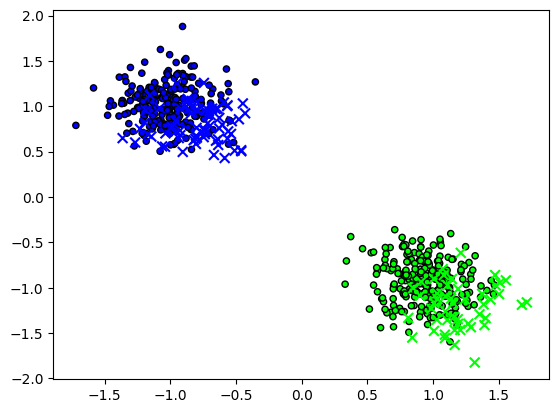

In [1833]:
n_features = 2
n_classes = 2
n_samples= 600
cluster_std = 0.8


X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=cluster_std, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x', s=50, label='Test')

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [1834]:
mlp_2 = NeuralNetwork(loss=NeuralNetwork.loss_mse)

mlp_2.add(LayerDense(n_features, 6, LayerDense.relu))
mlp_2.add(LayerDense(6, 1, LayerDense.sigmoid))

Total iterations 480
Iterations of each epoch 48
Validation set size: 48
Training set size: 432
Epoch: 0/10 | loss 0.09444310953336814 | accuracy 1.0 | validation loss 0.08887406765314783 | validation accuracy 1.0
Epoch: 1/10 | loss 0.06438200172946311 | accuracy 1.0 | validation loss 0.062303380583108386 | validation accuracy 1.0
Epoch: 2/10 | loss 0.04520952178800238 | accuracy 1.0 | validation loss 0.04495343826059356 | validation accuracy 1.0
Epoch: 3/10 | loss 0.03383274359763567 | accuracy 1.0 | validation loss 0.0343701653565485 | validation accuracy 1.0
Epoch: 4/10 | loss 0.026812780790057902 | accuracy 1.0 | validation loss 0.0276621534943147 | validation accuracy 1.0
Epoch: 5/10 | loss 0.022150714987235934 | accuracy 1.0 | validation loss 0.023099727230397948 | validation accuracy 1.0
Epoch: 6/10 | loss 0.01885642003957137 | accuracy 1.0 | validation loss 0.01980856580991848 | validation accuracy 1.0
Epoch: 7/10 | loss 0.016412619815953784 | accuracy 1.0 | validation loss 0.0

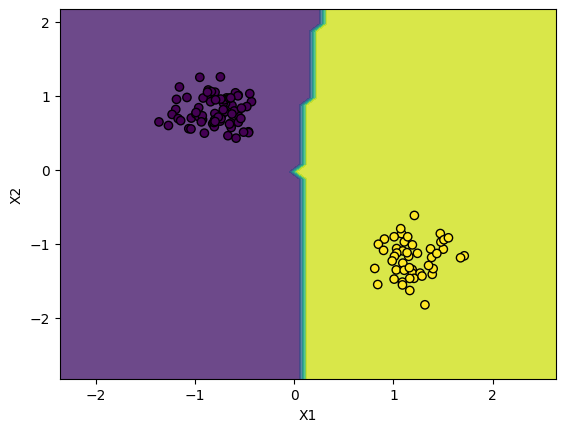

In [1835]:
reshaped_y_true = y_train.reshape(-1, 1)  # [1, 0, 0, 0] -> [[1], [0], [0], [0]] | since here we have outputs from 

mlp_2.fit(X_train, reshaped_y_true, 0.03, 10, 10)

plot_decision_boundary(mlp_2, X_test, y_test.reshape(-1, 1))

<h2> Output Softmax (n classes) </h2>

X_train shape: (240, 2)
y_train shape: (240, 4)
X_test shape: (60, 2)
y_test shape: (60, 4)


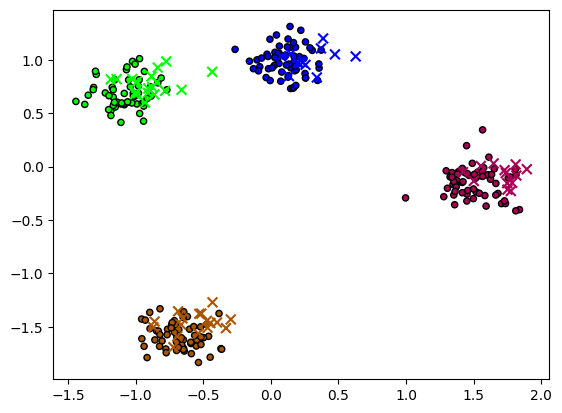

In [1836]:
n_features = 2
n_classes = 4
n_samples= 300
cluster_std = 0.8


X, y = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_classes, cluster_std=cluster_std, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = standard_scaler(X_train)
X_test = standard_scaler(X_test)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.brg, edgecolor='k', s=20, label='Train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.brg, marker='x', s=50, label='Test')


encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train.reshape(-1, 1))
y_test = encoder.transform(y_test.reshape(-1, 1))

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

In [1333]:
# scaler = StandardScaler()

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [1837]:
mlp_n_class = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_n_class.add(LayerDense(n_features, 16, LayerDense.relu))
mlp_n_class.add(LayerDense(16, n_classes, LayerDense.softmax))

Total iterations 240
Iterations of each epoch 24
Validation set size: 24
Training set size: 216
Epoch: 0/10 | loss 0.316589493255481 | accuracy 0.2361111111111111 | validation loss 0.3069021552296091 | validation accuracy 0.25
Epoch: 1/10 | loss 0.24730119839710912 | accuracy 0.3287037037037037 | validation loss 0.24417808713487374 | validation accuracy 0.375
Epoch: 2/10 | loss 0.1956433185077833 | accuracy 0.7129629629629629 | validation loss 0.19804485607176972 | validation accuracy 0.7083333333333334
Epoch: 3/10 | loss 0.15949517958098736 | accuracy 0.7407407407407407 | validation loss 0.16581639684786753 | validation accuracy 0.7083333333333334
Epoch: 4/10 | loss 0.13460602105358976 | accuracy 0.7407407407407407 | validation loss 0.14314199556629156 | validation accuracy 0.7083333333333334
Epoch: 5/10 | loss 0.11685276504140824 | accuracy 0.7407407407407407 | validation loss 0.1265345687392249 | validation accuracy 0.7083333333333334
Epoch: 6/10 | loss 0.10329595373365476 | accurac

C:\Users\ferra\AppData\Local\Temp\ipykernel_10564\1963356961.py:48: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x=X[np.argmax(y, axis=1) == cl, 0],


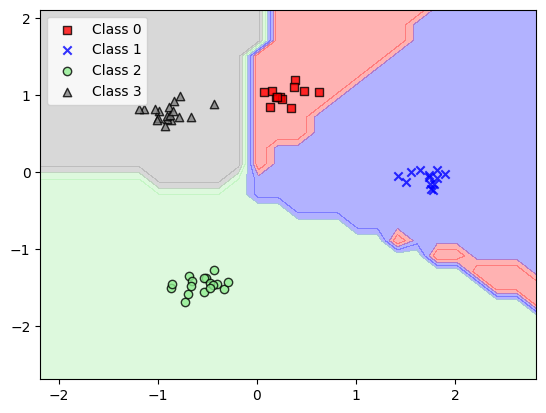

In [1838]:
mlp_n_class.fit(X_train, y_train, 0.01, 10, 10)

plot_decision_boundary_one_hot(mlp, X_test, y_test, 0.2)

In [1839]:
mlp_n_class.evaluate(X_test, y_test)

(0.06754501029809537, 1.0)

<h1> Testing MNIST </h1>

In [1840]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [1841]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

partition = 1
train_images = train_images[:int(len(train_images) * partition)]
train_labels = train_labels[:int(len(train_labels) * partition)]
test_images = test_images[:int(len(test_images) * partition)]
test_labels = test_labels[:int(len(test_labels) * partition)]

# # Preprocess the data
train_images = train_images / 255.0
test_images = test_images / 255.0
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')

Train images shape: (60000, 28, 28)
Train labels shape: (60000, 10)
Test images shape: (10000, 28, 28)
Test labels shape: (10000, 10)


In [1864]:
np.random.seed(0)

mlp_mnist = NeuralNetwork(loss=NeuralNetwork.loss_categorical_crossentropy)

mlp_mnist.add(LayerDense(784, 64, LayerDense.relu))
mlp_mnist.add(LayerDense(64, 32, LayerDense.relu))
mlp_mnist.add(LayerDense(32, 10, LayerDense.softmax))

In [1865]:
mlp_mnist.fit(train_images.reshape(-1, 784), train_labels, 0.01, 40, 200)

Total iterations 12000
Iterations of each epoch 300
Validation set size: 6000
Training set size: 54000
Epoch: 0/40 | loss 0.2438718019403402 | accuracy 0.09031481481481482 | validation loss 0.24466356005695925 | validation accuracy 0.08833333333333333
Epoch: 1/40 | loss 0.16178260527135174 | accuracy 0.48138888888888887 | validation loss 0.15790175406949886 | validation accuracy 0.501
Epoch: 2/40 | loss 0.11280190109484438 | accuracy 0.657074074074074 | validation loss 0.10584116513796929 | validation accuracy 0.6948333333333333
Epoch: 3/40 | loss 0.08460856848541719 | accuracy 0.7834629629629629 | validation loss 0.07679179997747275 | validation accuracy 0.8236666666666667
Epoch: 4/40 | loss 0.06607410052331743 | accuracy 0.8449074074074074 | validation loss 0.05823699585747575 | validation accuracy 0.8765
Epoch: 5/40 | loss 0.054548215338278784 | accuracy 0.8625185185185186 | validation loss 0.04677644554483349 | validation accuracy 0.8916666666666667
Epoch: 6/40 | loss 0.04771092904

# Test evaluation loss, accuracy

In [1900]:
mlp_mnist.evaluate(test_images.reshape(-1, 784), test_labels)

(0.019818447101844085, 0.9423)

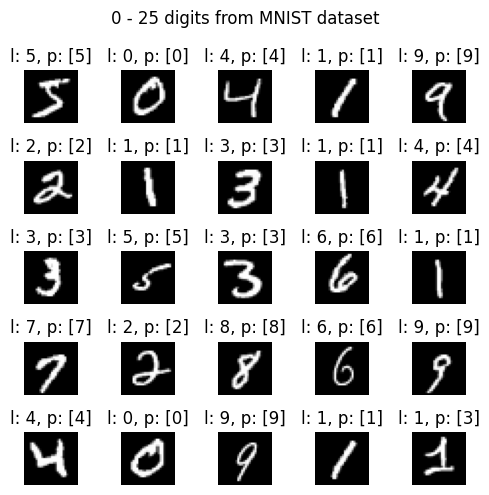

In [1884]:
fig, axes = plt.subplots(5, 5, figsize=(5, 5))

plt.suptitle('0 - 25 digits from MNIST dataset')

for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i], cmap='gray')
    ax.axis('off')

    label = train_labels[i].argmax()
    prediction = mlp_mnist.predict(train_images[i].reshape(-1, 784))

    ax.set_title(f'l: {label}, p: {prediction}')
    # padding
    
plt.tight_layout()

In [ ]:
image = cv2.imread('digit_image.png', cv2.IMREAD_GRAYSCALE)
image = image / 255.0

print(mlp_mnist.predict(image.reshape(1, 784)))

predictions = mlp_mnist.forward(image.reshape(1, 784))

prediction = np.argmax(predictions)
accuracy = np.max(predictions)

print(f'Prediction: {prediction} | Accuracy: {accuracy}')